# Workshop 5 - SARIMAX Forecasting

## Import and data

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
    One of the methods available in Python to model and predict future points of a time series is known as <b>SARIMAX</b>, which stands for <b> Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors</b>. 
<!--     https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3 -->

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
Classical approach for fitting an ARIMA model is to follow the Box-Jenkins Methodology.
    <ul>
<li><b>Model Identification</b>: Use plots and summary statistics to identify trends, and seasonality to get an idea the amount of differencing (d: degree of differencing) and the size of the lag (p: lag order)
<li><b>Model Estimation</b>: Estimate coefficients of the regression model. Maximum Likelihood
<li><b>Model Diagnostics</b>: Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model
    

In [ ]:
!pip install -U statsmodels
!pip install -U pmdarima

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
# 

from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.utils.plotting import plot_series

from sklearn.metrics import mean_squared_error

import pmdarima as pm

ModuleNotFoundError: No module named 'sktime'

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px'> 
    We’ll be working with a dataset called “Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.,” which collected CO2 samples from March 1958 to December 2001. 
    <!--     https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3 -->

In [2]:
dataset = sm.datasets.co2.load_pandas()
y_ = dataset.data
y_.head()


,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>For the first we will make a little preprocessing with data

In [3]:

# The 'MS' string groups the by start of the month
y = y_['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

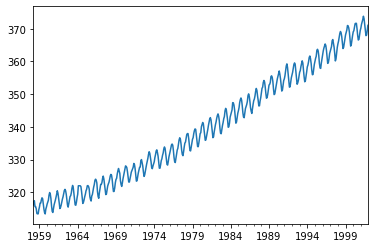

In [4]:
y.plot();

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
Some distinguishable patterns appear when we plot the data. The time series has an obvious seasonality pattern, as well as an overall increasing trend.

In [5]:
y.describe()


count    526.000000
mean     339.624826
std       17.110954
min      313.400000
25%      324.025000
50%      337.912500
75%      354.537500
max      373.800000
Name: co2, dtype: float64

## ARIMA Forecasting

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. <br>
There are three distinct integer-values parameters (orders) <code> (p, d, q)</code>  that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation <code>ARIMA(p, d, q)</code> :<ul>
    
<li><b>p</b> is the <b>auto-regressive part</b> of the model. It allows to incorporate the effect of past values into our model. The past values here are called <b> lagged observations </b> (also known as <b>“time lag” or “lag”</b>).
<ul>   Intuitively, this would be similar to say that it is likely to be warm tomorrow if it has been warm the past 3 days. In other words we can say here that our current value of temperature depends on the  past three values. </ul>
        
<li><b>d</b> is the <b>integrated part</b> of the model. This includes terms that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) in order to make the time-series stationary (to eliminate the trend part).
<ul> Intuitively, this would be similar to say that it is likely to be same growing of temperature each day (or the same acceleration for second derivative and so on). </ul>
    
<li><b>q</b> is the <b>moving average part</b> of the model. This allows to set the residual part (noise,error) of  model as a linear combination of the residual values observed at previous time points in the past.
    

<!--         https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3 -->
<!--     https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70 -->

### Arima Manual Order Selection

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
For the first let's considering the stationarity order of differentiation.<br>
    As a rule it is need to be 1-3 orders, and rarely more.

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
For checking the stationarity here we will use two techniques:<ul>
<li><b>Rolling Statistics</b>: Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis).
<li><b>Augmented Dickey-Fuller Test</b>: The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics.

<!-- https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7  -->

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
Rolling Test visually show mean value non-stationarity. And also we can see small variance decreasing.

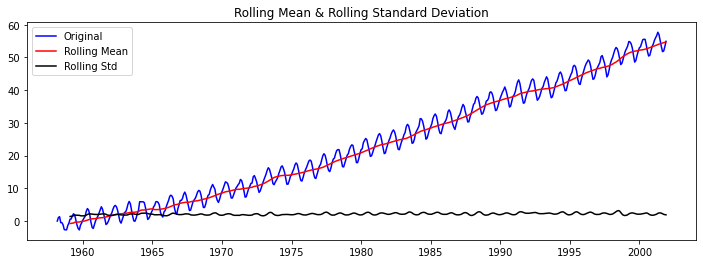

In [6]:

rolling_mean = y.rolling(window = 12).mean()
rolling_std  = y.rolling(window = 12).std()

plt.figure(figsize=(12,4))

plt.plot(y-y[0], color = 'blue', label = 'Original')
plt.plot(rolling_mean-y[0], color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()


<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
The ADF test also show that the <b>ADF Statistic</b> is far from the <b>critical values</b> and the $p$-value is greater than the threshold ($0.05$). Thus, we can conclude that the time series is not stationary.

In [7]:
result = adfuller(y)


print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 2.359809953995333
p-value: 0.9989901230798025
Critical Values:
	1%: -3.4432119442564324
	5%: -2.8672126791646955
	10%: -2.569791324979607


<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Now let's see the first difference

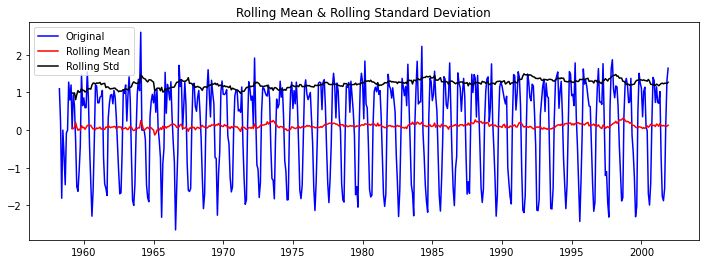

In [8]:
y_diff = y.diff(1)
# for fill obtained first NaN Value with next
y_diff = y_diff.dropna()

rolling_mean = y_diff.rolling(window = 12).mean()
rolling_std  = y_diff.rolling(window = 12).std()

plt.figure(figsize=(12,4))

plt.plot(y_diff, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Here and below we can see that our data now satisfy to stationary criteria.

In [9]:
y_diff.head()

1958-04-01    1.100000
1958-05-01    0.233333
1958-06-01   -1.808333
1958-07-01    0.000000
1958-08-01   -0.675000
Freq: MS, Name: co2, dtype: float64

In [10]:
result = adfuller(y_diff)


print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -5.063202630318491
p-value: 1.6614851317686715e-05
Critical Values:
	1%: -3.4432119442564324
	5%: -2.8672126791646955
	10%: -2.569791324979607


In [11]:
y_diff.head()

1958-04-01    1.100000
1958-05-01    0.233333
1958-06-01   -1.808333
1958-07-01    0.000000
1958-08-01   -0.675000
Freq: MS, Name: co2, dtype: float64

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'><ul><em>Note</em> <ul>
    Beside ADF there are exist a lot of tests, among them it is also valuable to check <ul>
    <li> ACF analysis - for the non-stationary process you will see slow decrease and other-wise for stationary.
    <li><b>Kwiatkowski–Phillips–Schmidt–Shin (KPSS)</b> test which is differ from ADF in the case of deterministic trend with inflection points.
    

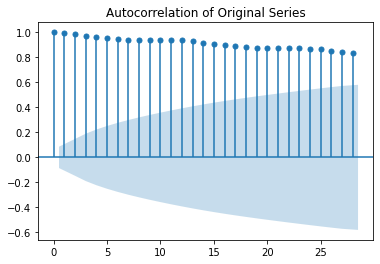

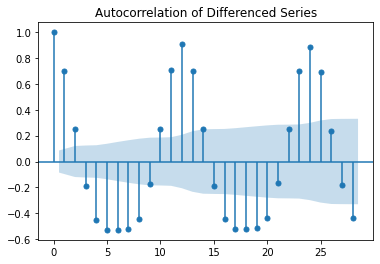

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Original Series
plot_acf(y[:], title='Autocorrelation of Original Series');plt.show()

# Usual Differencing
plot_acf(y_diff[:], title='Autocorrelation of Differenced Series');plt.show()

plt.show();

In [19]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(y_diff)

KPSS Statistic: 0.07042168811681968
p-value: 0.1
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>   
    
After integration order selection the AR and MA orders need to be selected.
<br> It can be the following recommendations about it 

<table style="width:90%, font-size:x-large">
    <caption>ARMA order selection</caption>  
    <thead style='text-align: center'>
        <tr  >
            <th>ACF Pattern</th>
            <th>PACF Pattern</th>
            <th>Conclusion</th>
        </tr>
    </thead>
    <tbody>
        <tr><td>Tapers to 0 in some fashion</td>
            <td>Non-zero values at first p points;<br> zero values elsewhere</td>
            <td>$AR(p)$ Model</td>
        </tr>
        <tr>
            <td>Non-zero values at first q points;<br> zero values elsewhere</td>
            <td>Tapers to 0 in some fashion</td>
            <td>MA(q) model</td>
        </tr>
        <tr>
            <td>Values that remain close to 1,<br> no tapering off</td>
            <td>Values that remain close to 1,<br> no tapering off</td>
            <td>Symptoms of a non-stationary series.<br> Differencing is most likely needed.</td>
        </tr> 
        <tr>
            <td>No significant correlations</td>
            <td>No significant correlations</td>
            <td>Random Series.</td>
        </tr>        
    </tbody>
</table>
<!--https://blog.minitab.com/en/starting-out-with-statistical-software/fitting-an-arima-model -->

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
<em>Note</em><ul>
    If your series is slightly <u>under-differenced</u>, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly <u>over-differenced</u>, try adding an additional MA term.    
<!-- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ -->




<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>

For estimating the <b>Autoregression order (AR order)</b> of the model lets analyze 
    <br><b>Partial - Autocorrelation plot (PACF)</b>.<br>
As a rule the plot consists the confidence intervals that is drawn as a cone area. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

<!-- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ -->

In [85]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


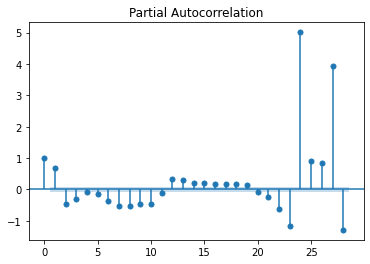

In [86]:
plot_pacf(y_diff);
plt.show()

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
The PACF plot shows that we have at least 1-rst order AR model with some additional effects such as seasonality or non-stationarity. <br>
    <em>Note</em> The plot is starting from lag-0, thus we can-not considering it.

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
Now we can make initial guess about the <b>Moving Average order (MA order)</b>.<br>
For this we will use <b>Autocorrelation plot (ACF)</b>.<br>
The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

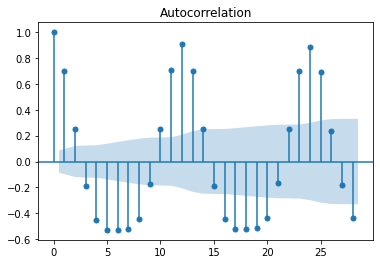

In [87]:
plot_acf(y_diff);
plt.show()

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
The ACF plot shows at least 2-nd order dependence in the our data with some seasonality. <br>

### ARIMA Model for first guess.

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
Let's try for the first our model with initial guess of orders (<code>ARMA(p=1,d=1,q=2)</code>.

In [88]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(y.values, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  526
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -607.411
Date:                Mon, 03 May 2021   AIC                           1222.822
Time:                        11:42:34   BIC                           1239.876
Sample:                             0   HQIC                          1229.500
                                - 526                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4018      0.073      5.529      0.000       0.259       0.544
ma.L1          0.5221      0.072      7.241      0.000       0.381       0.663
ma.L2          0.3636      0.057      6.379      0.0

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    The model summary reveals a lot of information.<br>
The first table shows the general information, including quality criterions (AIC, BIC and HQIC).
<br>
The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.
and $sigma2$ is the <b>RSS</b> error of the model.<br>
The last table are results of the different statistical tests on residual distribution.

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Beside tabular representation we can make graphical residuals diagnostic

C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


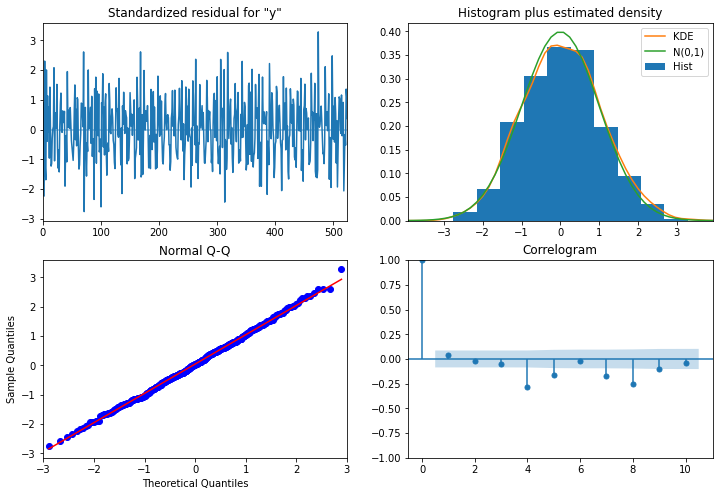

In [89]:
model_fit.plot_diagnostics(figsize=(12,8));

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
On the plots above we can see: <ul>
<li> The residual errors seem to fluctuate around a mean of zero and have a uniform variance (top left plot).
<li> The residual are almost have normal distribution (top right plot). <br>
<li> The Q-Q plot shows almost normal distribution also (bottom left, ideally all the dots should fall perfectly in line with the red line).
<li> However on the ACF plot (correlogram) we may notice some outliers above the confidence level (bottom right, any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model).
    
That mean - we may improve our model.

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    As the rapid guess we can try to increase the AR order of the model.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  526
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -533.373
Date:                Mon, 03 May 2021   AIC                           1076.745
Time:                        11:42:37   BIC                           1098.062
Sample:                             0   HQIC                          1085.092
                                - 526                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5539      0.034     45.970      0.000       1.488       1.620
ar.L2         -0.8466      0.038    -22.003      0.000      -0.922      -0.771
ma.L1         -0.8716      0.059    -14.654      0.0

C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


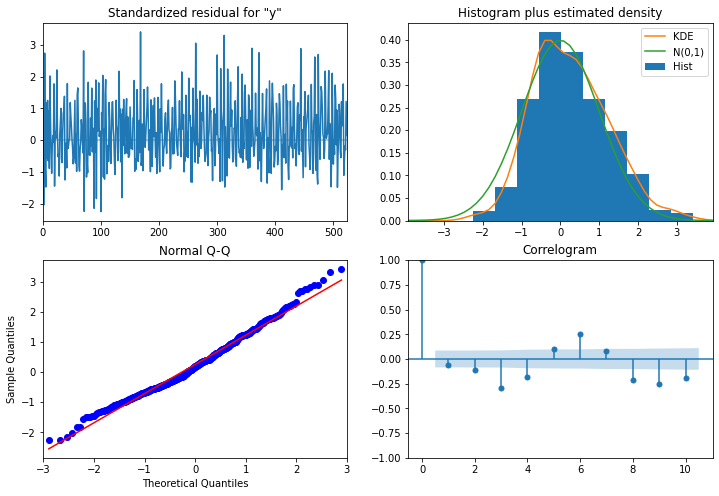

In [90]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(y.values, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(12,8));

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
As we can see here we decrease both AIC (and BIC..) criterion and RSS (sigma2) error  - that means that we moving in right direction. However we slightly deteriorate the residual behavior. <br>
    The search of the best parameters is complex task.

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Here we can also notice that we have ma.L2 component small and can try to eliminate it.
    

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  526
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -533.989
Date:                Mon, 03 May 2021   AIC                           1075.978
Time:                        11:42:40   BIC                           1093.032
Sample:                             0   HQIC                          1082.656
                                - 526                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5353      0.028     55.566      0.000       1.481       1.589
ar.L2         -0.8285      0.030    -27.249      0.000      -0.888      -0.769
ma.L1         -0.8117      0.037    -21.901      0.0

C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


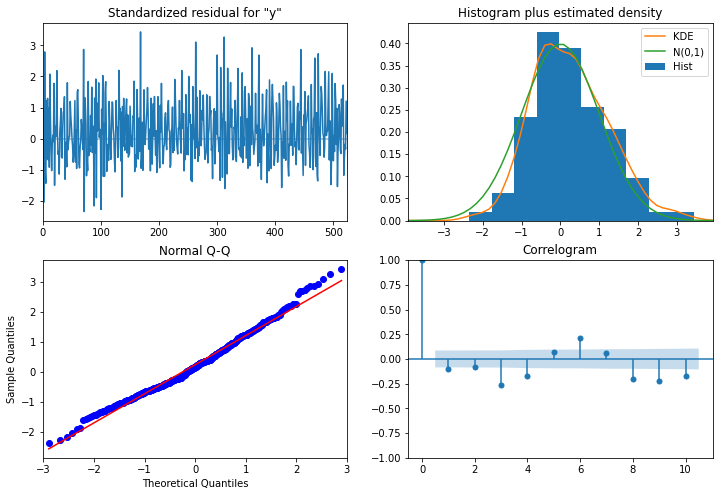

In [91]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(y.values, order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(12,8));

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Here we can see that indeed second term does not affect on the accuracy of data prediction.
    

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Now we can plot the fitted data<br>
    When you set dynamic=False the in-sample lagged values are used for prediction.<br>
That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

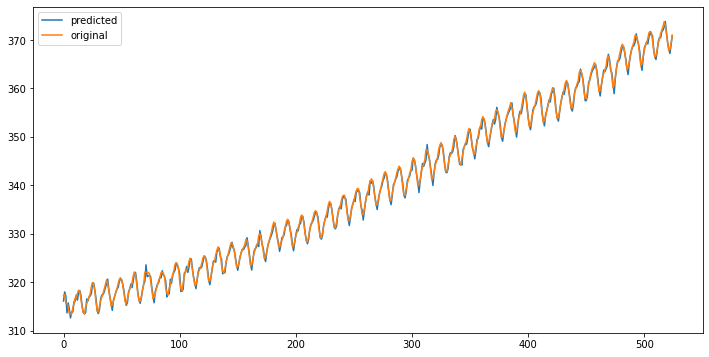

In [92]:
# Actual vs Fitted
y_hat = model_fit.predict(dynamic=False)

plt.figure(figsize=(12,6))
plt.plot(y_hat[1:], label='predicted')
plt.plot(y[1:].values, label='original')
plt.legend()
plt.show()

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Beside the in-time prediction we may check or data on test data.<br>
For this we may divide our data on two series -test and train. 

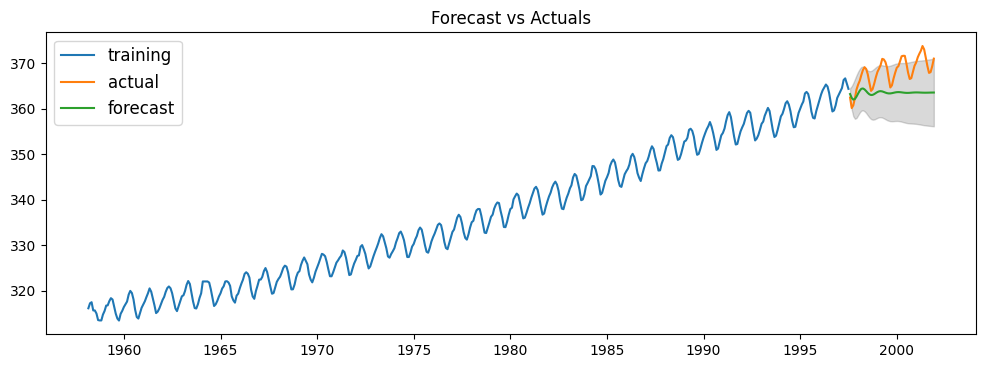

In [93]:
# Create Training and Test
train = y[:int(y.size*0.9)]
test = y[int(y.size*0.9):]

# Build Model
model = ARIMA(train, order=(2, 1, 1))  
fitted = model.fit()  

# Forecast
forecast_res = fitted.get_forecast(test.size, alpha=0.05, dynamic=False)  # 95% conf

# forecast = fitted.forecast(test.size, alpha=0.05)  # 95% conf
forecast = forecast_res.predicted_mean

# Make as pandas series
fc_series = pd.Series(forecast.values, index=test.index)

lower_series = pd.Series(forecast_res.conf_int()['lower co2'], index=test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper co2'], index=test.index)


# Plot
plt.figure(figsize=(12,4), dpi=100)

plt.plot(train, label='training')
plt.plot(test,  label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', 
                 alpha=0.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)

plt.show()

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Now we can see that our model was over-fitted.
  <br> For estimating accuracy of our forecast we can introduce the following measures

In [68]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mean absoute percentage error':mape, 
            'mean absoute error           ': mae, 
            'mean percentage error        ': mpe, 
            'root mean square             ':rmse, 
            'correlation coefficient      ':corr, 
            'minmax error                 ':minmax})

In [123]:
forecast_accuracy(fc_series.values, test.values)

{'mean absoute percentage error': 0.0037188201927048957,
 'mean absoute error           ': 1.370467806185665,
 'mean percentage error        ': -0.0036203570222564747,
 'root mean square             ': 1.448243682381261,
 'correlation coefficient      ': 0.984801545546153,
 'minmax error                 ': 0.003718716705316538}

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
We can choose better orders of the model, like it is shown below.

C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


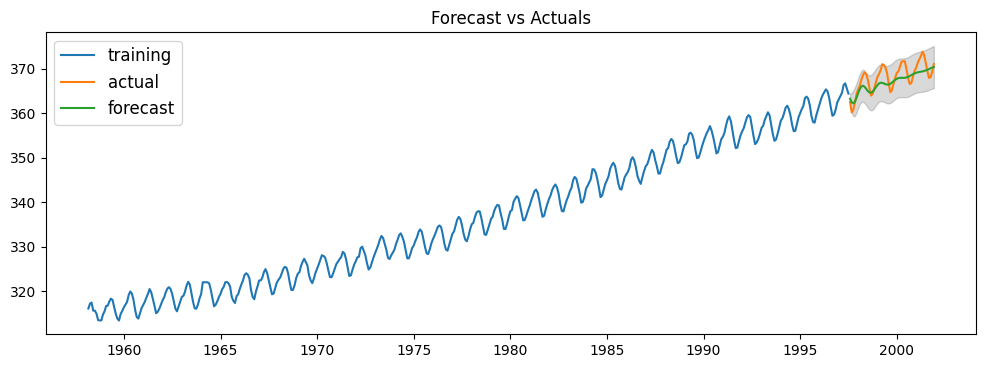

{'mean absoute percentage error': 0.0050279116520248295,
 'mean absoute error           ': 1.8565906438131856,
 'mean percentage error        ': -0.0030232064973775142,
 'root mean square             ': 2.2157261786757645,
 'correlation coefficient      ': 0.7836715399134366,
 'minmax error                 ': 0.005023574563809641}

In [124]:
# Create Training and Test
train = y[:int(y.size*0.9)]
test = y[int(y.size*0.9):]

# Build Model
model = ARIMA(train, order=(3, 2, 2))  
fitted = model.fit()  

# Forecast
forecast_res = fitted.get_forecast(test.size, alpha=0.05, dynamic=False)  # 95% conf
forecast = forecast_res.predicted_mean

# forecast = fitted.forecast(test.size, alpha=0.05)  # Alternative method 


# Make as pandas series
fc_series = pd.Series(forecast.values, index=test.index)

lower_series = pd.Series(forecast_res.conf_int()['lower co2'], index=test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper co2'], index=test.index)


# Plot
plt.figure(figsize=(12,4), dpi=100)

plt.plot(train, label='training')
plt.plot(test,  label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', 
                 alpha=0.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)

plt.show()

forecast_accuracy(fc_series.values, test.values)

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Here we can see that our measures become significantly better.

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Beside the manual choosing of the ARIMA parameters we can use auto-arima search using <code>pmdarima</code> library.

In [21]:
import pmdarima as pm

model = pm.auto_arima(y, 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=10, 
                      max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1268.116, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1676.811, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1328.472, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1374.168, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1678.850, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1010.848, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1205.382, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1009.758, Time=0.53 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1150.521, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1008.632, Time=0.91 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1149.017, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=947.708, Time=1.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1138.051, Time=0.18 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=833.411, Time=1.28 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  526
Model:              SARIMAX(10, 1, 2)   Log Likelihood                -234.469
Date:                Tue, 04 May 2021   AIC                            496.938
Time:                        14:11:30   BIC                            556.626
Sample:                             0   HQIC                           520.311
                                - 526                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3105      0.028     11.163      0.000       0.256       0.365
ar.L1          0.7235      0.060     12.039      0.000       0.606       0.841
ar.L2         -0.8153      0.053    -15.298      0.000      -0.920      -0.711
ar.L3         -0.1545      0.060     -2.592      0.010      -0.271      -0.038
ar.L4         -0.1730      0.061     -2.850      0.004      -0.292      -0.054
ar.L5         -0.2430      0.065     -3.737      0.000      -0.371      -0.116
ar.L6         -0.2120      0.066     -3.228      0.001      -0.341      -0.083
ar.L7         -0.2672      0.063     -4.211      0.000      -0.392      -0.143
ar.L8         -0.2796      0.064     -4.349      0.000      -0.406      -0.154
ar.L9         -0.1906      0.057     -3.368      0.001      -0.301      -0.080
ar.L10        -0.2236      0.052     -4.294      0.000      -0.326      -0.122
ma.L1         -0.8896      0.047    -18.940      0.000      -0.982      -0.798
ma.L2          0.7777      0.037     21.013      0.000       0.705       0.850
sigma2         0.1406      0.008     17.405      0.000       0.125       0.156
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):                 7.85
Prob(Q):                              0.33   Prob(JB):                         0.02
Heteroskedasticity (H):               0.66   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Here the search propose us to use model <code>ARIMA(10,1,2)</code> Let's test it.

C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


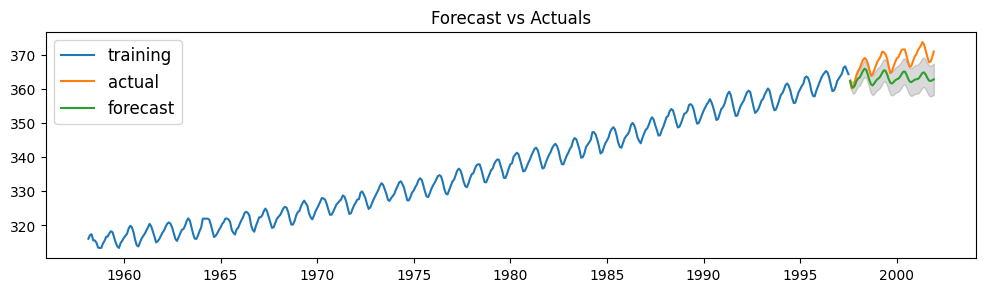

{'mape': 0.01330633295669916,
 'me': -4.89114134519186,
 'mae': 4.914562517264946,
 'mpe': -0.013241301241932851,
 'rmse': 5.379130185554309,
 'corr': 0.7410145431091859,
 'minmax': 0.013306277017209989}

In [105]:
# Create Training and Test
train = y[:int(y.size*0.9)]
test = y[int(y.size*0.9):]

# Build Model
model = ARIMA(train, order=(10, 1, 2))  
fitted = model.fit()  

# Forecast
forecast_res = fitted.get_forecast(test.size, alpha=0.05, dynamic=False)  # 95% conf

# forecast = fitted.forecast(test.size, alpha=0.05)  # 95% conf
forecast = forecast_res.predicted_mean

# Make as pandas series
fc_series = pd.Series(forecast.values, index=test.index)

lower_series = pd.Series(forecast_res.conf_int()['lower co2'], index=test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper co2'], index=test.index)


# Plot
plt.figure(figsize=(12,3), dpi=100)

plt.plot(train, label='training')
plt.plot(test,  label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', 
                 alpha=0.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)

plt.show()

forecast_accuracy(fc_series.values, test.values)

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    As we can see auto-search does not guaranty best results in the forecast. <br> It is due to lack of cross-validation<br>
    However here we can probably improve it manually.

C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


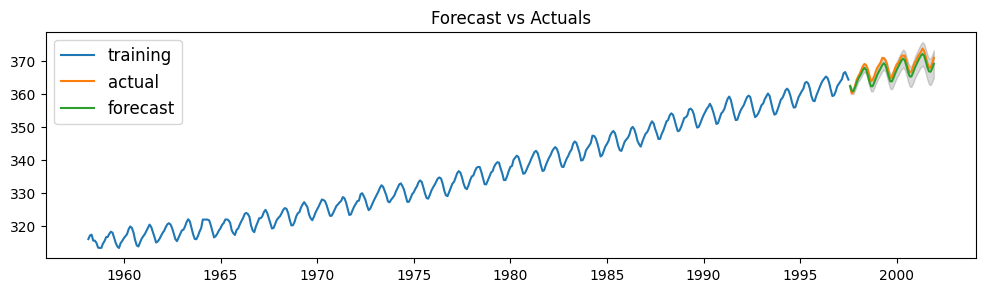

{'mape': 0.0037188201927048957,
 'me': -1.3349999198951579,
 'mae': 1.370467806185665,
 'mpe': -0.0036203570222564747,
 'rmse': 1.448243682381261,
 'corr': 0.984801545546153,
 'minmax': 0.003718716705316538}

In [113]:
# Create Training and Test
train = y[:int(y.size*0.9)]
test = y[int(y.size*0.9):]

# Build Model
model = ARIMA(train, order=(10, 2,8))  
fitted = model.fit()  

# Forecast
forecast_res = fitted.get_forecast(test.size, alpha=0.05, dynamic=False)  # 95% conf

# forecast = fitted.forecast(test.size, alpha=0.05)  # 95% conf
forecast = forecast_res.predicted_mean

# Make as pandas series
fc_series = pd.Series(forecast.values, index=test.index)

lower_series = pd.Series(forecast_res.conf_int()['lower co2'], index=test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper co2'], index=test.index)


# Plot
plt.figure(figsize=(12,3), dpi=100)

plt.plot(train, label='training')
plt.plot(test,  label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', 
                 alpha=0.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)

plt.show()

forecast_accuracy(fc_series.values, test.values)

### Exercise 1

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'><ol>
<li> Try to simulate Random-Walk process (from the workshop 2) and look for the best ARIMA model for it.
<li> Try to simulate some time series with logistic trend small seasonality, small holidays effect and search the best ARIMA model for it. 
<li> Take dataset of air line passenger (from the workshop 4) and try to find best model for it forecasting.

## Seasonal ARIMA (SARIMA) model

### Importance of the Seasonal Difference 

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
The problem with plain ARIMA model is it does not support non-stationary seasonality.<br>
If the time series has defined significant seasonality effect, then, go for SARIMA which uses seasonal differencing.<br>
Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.
    <blockquote>
<em>Notes</em> When dealing with seasonal effects, we make use of the <b>seasonal ARIMA (SARIMA)</b>, which is denoted as <code>SARIMA(p,d,q)(P,D,Q)s</code>. Here, <code>(p, d, q)</code> are the non-seasonal parameters described above, while <code>(P, D, Q)</code> follow the same definition but are applied to the seasonal component of the time series. The term <code>s</code> is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    For the first let's see how seasonal differencing work

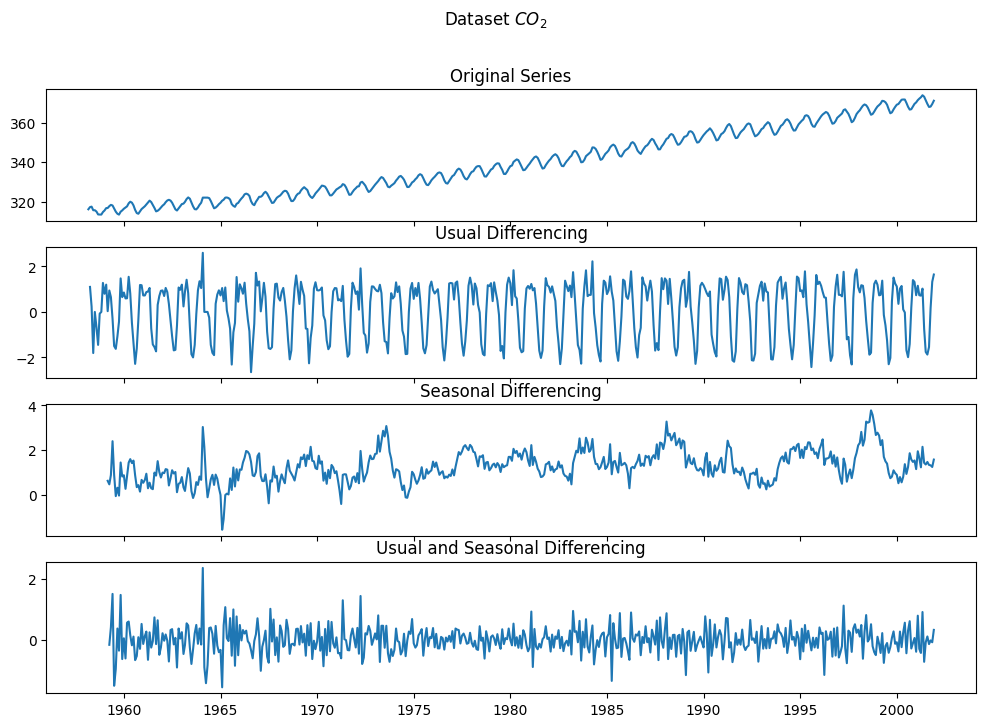

In [138]:
SEASON = 12

# Plot
fig, axes = plt.subplots(4, 1, figsize=(12,8), dpi=100, sharex=True)

# Original Series
axes[0].plot(y[:])
axes[0].set_title('Original Series')

# Usual Differencing
axes[1].plot(y[:].diff(1))
axes[1].set_title('Usual Differencing')

# Seasinal Differencing
axes[2].plot(y[:].diff(SEASON))
axes[2].set_title('Seasonal Differencing')

# Seasinal and Usual Differencing
axes[3].plot(y[:].diff(1).diff(SEASON))
axes[3].set_title('Usual and Seasonal Differencing')

plt.suptitle('Dataset $CO_2$', fontsize=12)
plt.show()

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    As we can see seasonal difference can help to make data more stationary.

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'><ul><em>Note</em><ul>
<li> Actually as we can see on the Usual Differencing Plot we have at least two seasonal components with different periods, but by taking one seasonal difference we exclude almost all seasonal influence.<br>
<li> Let's see on the spectrum

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'><ul><em>Note</em><ul>
<li>    As we can see on the plots above, The Spectrum of Usual Differencing contains at least 4 components but all with the same step (i.e. one with period 12, next with period 24 and so on). Due to this we eliminate all seasonal components on the bottom plot.<br>
    <li> It is also necessary to note that trend is the lowest frequency part (see beginning of the spectrum). Thus we almost exclude trend influence. 
        <ul> However the rest of the trend influence we exclude by taking second difference. this confirms our assumption of taking second order difference in the examples above.

### Exercise 2

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'><ol>
<li> Check KPSS and ADF values for original data; data with Usual Differencing; Second Usual Differencing; data with Seasonal Differencing; and data with both Differencing.
<li> Check ACF and PACF plot and make conclusions about order for data with Second Usual Differencing; data with Seasonal Differencing; and data with both Differencing.    
<li> Check and prove why you do not need to take 3-rd usual difference and second seasonal difference.     


### SARIMA Order Selection

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    In the explanation above we have notice that seasonal difference make data more stationary. <br>
    Then we need to choose the best initial guess about orders of SARIMA.<br>
<em>Rules of initial orders selection</em><ol>
<li><b>The correct order $d$ </b> is the order of differencing <u>that yields a time series with a noise like behavior </u><ul>i.e. fluctuates around a well-defined mean value and almost constant scatter, check for stationary by criterions named above.</ul>
<li><u>Use seasonal derivative only in the case of strong seasonal pattern.</u><br>
<li> Then considering ACF and PACF for differenced series.<ul>  
    <li> The numbers of <b>AR terms</b> is determined as <u>the last PACF lag before rapid decreasing</u> from positive values to zero. 
<li> The numbers of <b>MA terms</b>  is determined as <u>the last ACF lag before rapid increasing</u> from negative values to zero.     
<li>Add an <b>SAR term</b>, <u>If ACF is periodically positive</u>.
    <ul> Beside This the order be derived from PACF.<ul> Look at the number of significant lags, which are the multiples of the season period length.<ul> For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial  P  should be 2.</ul></ul></ul>
<li>Add an <b>SMA term</b>, <u>If ACF is periodically negative</u>.   
    <ul> Use the same rules of determine the number of lagas as for SAR</ul>
<em>Note </em><ul>
    <li>If your series is slightly <b>under-differenced</b>, <u>add additional AR terms</u>. 
    <li>If your series is slightly <b>over-differenced</b>,<u>add additional MA terms</u>.   
    <li>Try to avoid using more than one or two seasonal parameters (SAR + SMA) in the same model, as this is likely to lead to overfitting of the data and / or problems in estimation.
    <li> if the series has <b>positive ACF values out to a high lag</b> <u>.add differencing order</u>.    

In [184]:
import pmdarima as pm



# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, 
                       start_p=10, #Search for Usual AR order
                       start_q=1,  #Search for Usual MA order 
                       test='adf',
                       max_p=10, 
                       max_q=10, 
                       d=None, #Search for Usual Difference Order
                       m=12,   #The period for seasonal differencing                    
                       seasonal=True, #SARIMA ENABLE
                       start_P=0, #Search for Seasonal AR order
                       start_Q=0, #Search for Seasonal MA order
                       D=None, #Search for Seasonal Difference Order
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(10,1,1)(0,0,0)[12] intercept   : AIC=519.755, Time=1.98 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1500.491, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1025.470, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1502.018, Time=0.01 sec
 ARIMA(10,1,1)(1,0,0)[12] intercept   : AIC=513.823, Time=5.88 sec
 ARIMA(10,1,1)(2,0,0)[12] intercept   : AIC=483.623, Time=20.12 sec
 ARIMA(10,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=18.83 sec
 ARIMA(10,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=5.53 sec
 ARIMA(9,1,1)(2,0,0)[12] intercept   : AIC=481.660, Time=15.57 sec
 ARIMA(9,1,1)(1,0,0)[12] intercept   : AIC=564.281, Time=4.26 sec
 ARIMA(9,1,1)(2,0,1)[12] intercept   : AIC=435.565, Time=16.06 sec
 ARIMA(9,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=4.43 sec
 ARIMA(9,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=27.89 sec
 ARIMA(9,1,1)(1,0,2)[12] intercept   : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  473
Model:             SARIMAX(6, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -170.826
Date:                                 Mon, 03 May 2021   AIC                            363.652
Time:                                         16:45:14   BIC                            409.378
Sample:                                              0   HQIC                           381.638
                                                 - 473                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2816      0.144      1.956      0.050      -0.001       0.564
ar.L2         -0.0111      0.033     -0.337      0.736      -0.076       0.053
ar.L3         -0.1518      0.063     -2.425      0.015      -0.274      -0.029
ar.L4          0.0018      0.036      0.050      0.960      -0.069       0.073
ar.L5          0.0127      0.045      0.282      0.778      -0.076       0.101
ar.L6         -0.0934      0.045     -2.079      0.038      -0.181      -0.005
ma.L1         -0.5693      0.136     -4.187      0.000      -0.836      -0.303
ar.S.L12       0.9995      0.001   1926.967      0.000       0.998       1.000
ma.S.L12      -0.8511      0.044    -19.237      0.000      -0.938      -0.764
ma.S.L24      -0.0268      0.042     -0.634      0.526      -0.110       0.056
sigma2         0.1088      0.006     19.283      0.000       0.098       0.120
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                99.33
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>

So the auto-search propose to use <code> SARIMAX(6, 1, 1)x(1, 0, [1, 2], 12)</code>
<br>Let's test it

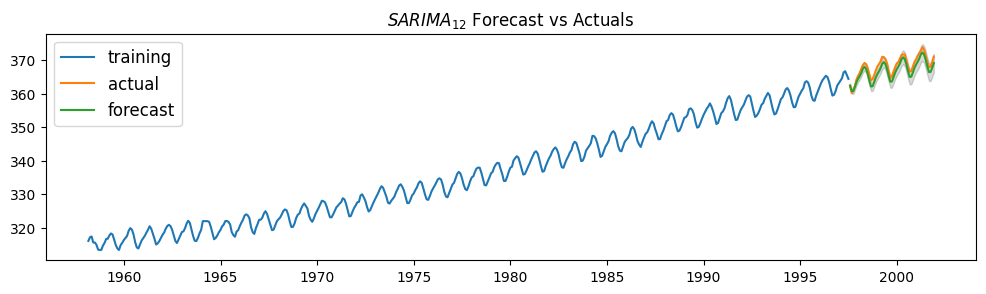

{'mean absoute percentage error': 0.003947772742976413,
 'mean absoute error           ': 1.454722139505576,
 'mean percentage error        ': -0.0038805878660586987,
 'root mean square             ': 1.5338558138656706,
 'correlation coefficient      ': 0.9846420347534222,
 'minmax error                 ': 0.003947716428085446}

In [200]:

fitted, confint = smodel.predict(n_periods=test.size,
                                 return_conf_int=True)

# make series for plotting purpose
fc_series    = pd.Series(fitted, index=test.index)
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)


# Plot
plt.figure(figsize=(12,3), dpi=100)

plt.plot(train, label='training')
plt.plot(test,  label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', 
                 alpha=0.15)

plt.title('$SARIMA_{12}$ Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)

plt.show()

forecast_accuracy(fc_series.values, test.values)





<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
Let's  Also test it with <code> statmodels SARIMA</code> function

C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


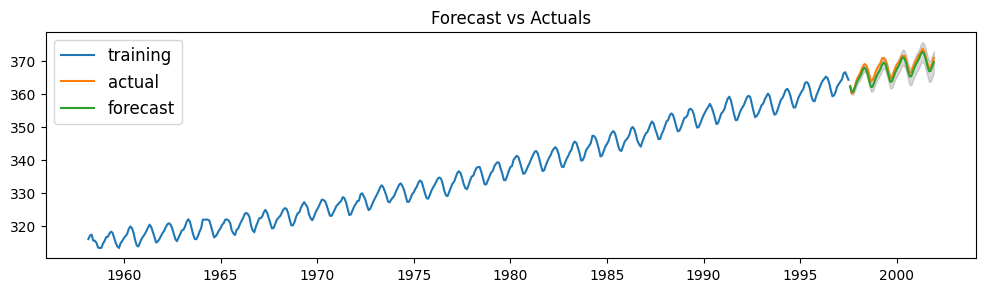

{'mean absoute percentage error': 0.0031670916924645934,
 'mean absoute error           ': 1.166196574986573,
 'mean percentage error        ': -0.0031093048607534345,
 'root mean square             ': 1.2596568798934529,
 'correlation coefficient      ': 0.9850223690012644,
 'minmax error                 ': 0.0031670475141546417}

In [205]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = sm.tsa.statespace.SARIMAX(train,
                                  order=(10, 2, 8),
                                  seasonal_order=(1, 1, 2, 12))

fitted = model.fit()  

# Forecast
forecast_res = fitted.get_forecast(test.size, alpha=0.05, dynamic=False)  # 95% conf

# forecast = fitted.forecast(test.size, alpha=0.05)  # 95% conf
forecast = forecast_res.predicted_mean

# Make as pandas series
fc_series = pd.Series(forecast.values, index=test.index)

lower_series = pd.Series(forecast_res.conf_int()['lower co2'], index=test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper co2'], index=test.index)


# Plot
plt.figure(figsize=(12,3), dpi=100)

plt.plot(train, label='training')
plt.plot(test,  label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', 
                 alpha=0.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)

plt.show()

forecast_accuracy(fc_series.values, test.values)

### Exercise 3

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'><ol>
<li> Compare the obtained by auto-search results with our initial supposition about first usual difference and first seasonal difference.
<li> Compare previous with supposition about second usual difference. Choose the best order of model between considered ones.


### SARIMAX (SARIMA with exogenous variable)

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    In some cases we can improve the accuracy of the model prediction, by introducing exogenous variable. The main requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well. In other, the exogenous variable can be anyone, independent to the training data. 

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    For Instance in our toy examples we can extract season component in the test data and considering it as exogenous variable for training data.<br>
    We will do it by <code>seasonal_decompose</code> routine.<br>
    Then we extrapolate the last year seasonal component values to the full data set.<br>
    But for the first we create dataframe

In [111]:
#ReSample to DataFrame

y = y_['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

ydf = pd.DataFrame(y)
ydf.columns = ['endog']
ydf.head()

,endog
1958-03-01,316.100000
1958-04-01,317.200000
1958-05-01,317.433333
1958-06-01,315.625000
1958-07-01,315.625000


<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Create new dataframe with co2 as training data (endog) end exogenous variable (exog)

In [116]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose

y = y_['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

ydf = pd.DataFrame(y)
ydf.columns = ['endog']
ydf.head()

# multiplicative seasonal component
result_mul = seasonal_decompose(ydf.endog,   # 3 years
                                model='multiplicative')

seasonal_index = result_mul.seasonal[-24:].to_frame()

seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
ydf['month'] = ydf.index.month

ydf = pd.merge(ydf, seasonal_index, how='left', on='month')
ydf.columns = ['endog', 'month', 'exog']


ydf.head(12)

,endog,month,exog
0,316.100000,3,1.004239
1,316.100000,3,1.004239
2,317.200000,4,1.007380
3,317.200000,4,1.007380
4,317.433333,5,1.008577
5,317.433333,5,1.008577
6,315.625000,6,1.006689
7,315.625000,6,1.006689
8,315.625000,7,1.002177
9,315.625000,7,1.002177


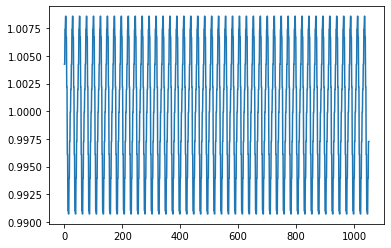

In [117]:
ydf.exog.plot();


<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> Make train test split for dataframes

In [118]:
train , test = pm.model_selection.train_test_split(ydf,test_size=0.1)


In [34]:
# Seasonal - fit stepwise auto-ARIMA
sxmodel = pm.auto_arima(train.endog, 
                        exogenous = train.exog.values.reshape(-1,1),
                        start_p=10, #Search for Usual AR order
                        start_q=1,  #Search for Usual MA order 
                        test='adf',
                        max_p=10, 
                        max_q=10, 
                        d=None, #Search for Usual Difference Order
                        m=12,   #The period for seasonal differencing                    
                        seasonal=True, #SARIMA ENABLE
                        start_P=0, #Search for Seasonal AR order
                        start_Q=0, #Search for Seasonal MA order
                        D=None, #Search for Seasonal Difference Order
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(10,1,1)(0,0,0)[12] intercept   : AIC=296.674, Time=2.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=332.551, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=316.706, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=311.755, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=372.107, Time=0.08 sec
 ARIMA(10,1,1)(1,0,0)[12] intercept   : AIC=296.680, Time=4.98 sec
 ARIMA(10,1,1)(0,0,1)[12] intercept   : AIC=296.619, Time=2.98 sec
 ARIMA(10,1,1)(1,0,1)[12] intercept   : AIC=299.271, Time=5.72 sec
 ARIMA(10,1,1)(0,0,2)[12] intercept   : AIC=298.551, Time=9.68 sec
 ARIMA(10,1,1)(1,0,2)[12] intercept   : AIC=300.372, Time=8.92 sec
 ARIMA(9,1,1)(0,0,1)[12] intercept   : AIC=295.174, Time=2.97 sec
 ARIMA(9,1,1)(0,0,0)[12] intercept   : AIC=295.872, Time=3.38 sec
 ARIMA(9,1,1)(1,0,1)[12] intercept   : AIC=298.494, Time=6.89 sec
 ARIMA(9,1,1)(0,0,2)[12] intercept   : AIC=297.171, Time=18.97 sec
 ARIMA(9,1,1)(1,0,0)[12] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  473
Model:             SARIMAX(8, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -134.837
Date:                              Mon, 03 May 2021   AIC                            293.675
Time:                                      22:38:33   BIC                            343.558
Sample:                                           0   HQIC                           313.297
                                              - 473                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2309      0.030      7.823      0.000       0.173       0.289
x1           336.3614      4.631     72.635      0.000     327.285     345.438
ar.L1         -0.2627      0.037     -7.096      0.000      -0.335      -0.190
ar.L2         -0.1614      0.039     -4.099      0.000      -0.239      -0.084
ar.L3         -0.2515      0.047     -5.318      0.000      -0.344      -0.159
ar.L4         -0.1415      0.052     -2.707      0.007      -0.244      -0.039
ar.L5         -0.0650      0.055     -1.173      0.241      -0.174       0.044
ar.L6         -0.1158      0.053     -2.173      0.030      -0.220      -0.011
ar.L7         -0.1117      0.048     -2.312      0.021      -0.206      -0.017
ar.L8         -0.1129      0.048     -2.358      0.018      -0.207      -0.019
ma.S.L12       0.0983      0.048      2.044      0.041       0.004       0.193
sigma2         0.1036      0.005     20.190      0.000       0.094       0.114
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               157.98
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> Let's try prediction on the auto-configurated data.

In [108]:
ex4test = pd.DataFrame(test.exog)
ex4test.head()

,exog
20752,0.996102
20753,0.996102
20754,0.996102
20755,0.996102
20756,0.996102


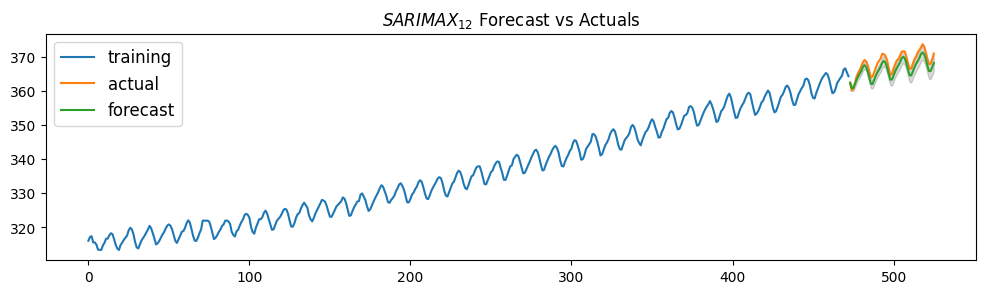

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':


{'mean absoute percentage error': 0.005060117981539687,
 'mean absoute error           ': 1.8659586807355004,
 'mean percentage error        ': -0.0049627858435570835,
 'root mean square             ': 1.9576150319647736,
 'correlation coefficient      ': 0.9820501688597131,
 'minmax error                 ': 0.0050600257762539735}

In [89]:

fitted, confint = sxmodel.predict(n_periods=np.shape(test.exog.values)[0],
                                  exogenous=ex4test,
                                  return_conf_int=True)

# make series for plotting purpose
fc_series    = pd.Series(fitted, index=test.index)
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)


# Plot
plt.figure(figsize=(12,3), dpi=100)

plt.plot(train.endog, label='training')
plt.plot(test.endog,  label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', 
                 alpha=0.15)

plt.title('$SARIMAX_{12}$ Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)

plt.show()

forecast_accuracy(fc_series.values, test.endog)

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> Let's Now try SARIMAX from statsmodels.

C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


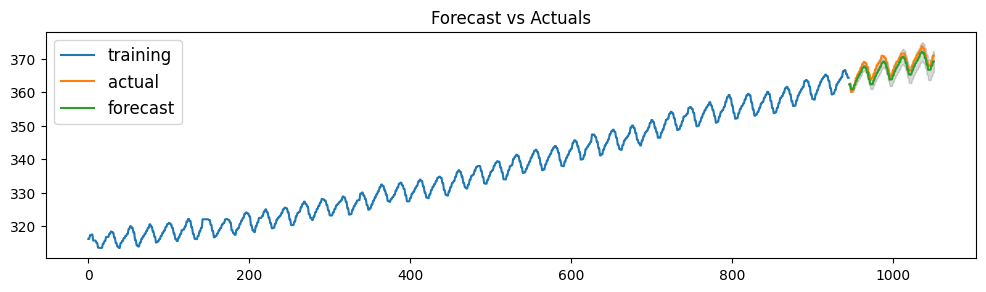

{'mean absoute percentage error': 0.0036812992027410066,
 'mean absoute error           ': 1.356824961133212,
 'mean percentage error        ': -0.0035763191213044553,
 'root mean square             ': 1.4331867044616442,
 'correlation coefficient      ': 0.9855394369808252,
 'minmax error                 ': 0.0036812000258082955}

In [122]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = sm.tsa.statespace.SARIMAX(endog=train.endog,
                                  exog =train.exog,
                                  order=(8, 2, 8),
                                  seasonal_order=(0, 0, 1, 12))

fitted = model.fit()  

# Forecast
forecast_res = fitted.get_forecast(test.endog.size, 
                                   exog    = test.exog, 
                                   alpha   = 0.05, 
                                   dynamic = False)  # 95% conf

forecast = forecast_res.predicted_mean

# Make as pandas series
fc_series = pd.Series(forecast.values, 
                      index=test.index)

lower_series = pd.Series(forecast_res.conf_int()['lower endog'], index=test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper endog'], index=test.index)


# Plot
plt.figure(figsize=(12,3), dpi=100)

plt.plot(train.endog, label='training')
plt.plot(test.endog,  label='actual')
plt.plot(fc_series,   label='forecast')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', 
                 alpha=0.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)

plt.show()

forecast_accuracy(fc_series.values, test.endog.values)

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> As we can see our toy exogenous factors does not affect much on prediction results. 